In [100]:
import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt
import helper_visa as vs
reload(vs)
import pyvisa
import joblib


In [6]:
# funcgen = vs.connect(timeout=30000) # set 30 second timeout
funcgen = vs.connect("TCPIP0::192.168.1.9::inst0::INSTR", timeout=30000) # set 30 second timeout
# vs.disconnect(funcgen)

Connected to VISA [TCPIP0::192.168.1.9::inst0::INSTR]:  Agilent Technologies,81160A,MY60410882,2.0.0.0-2.6



In [5]:
vs.disconnect(funcgen)

In [31]:
data = joblib.load("data_waveform/averaged_pulse_1pe_preamp_v4_40.7V.joblib")

time_series = data["time_series_ns"]
avg_pulse = data["averaged_pulse_1pe_volt"]

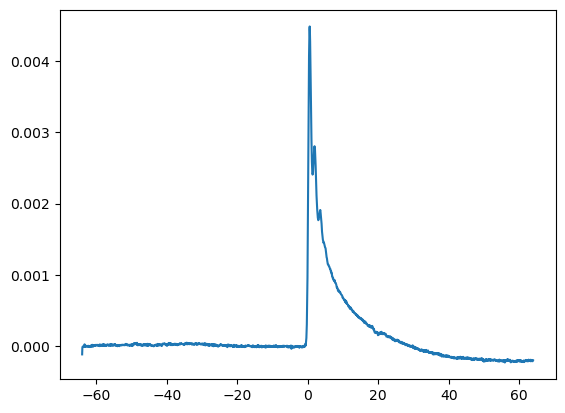

In [34]:
plot(time_series,avg_pulse)

In [29]:
min(time_series)

-0.625

/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_basic.py:61: RuntimeWarning: divide by zero encountered in true_divide
  pulse/=max(pulse)
/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_basic.py:61: RuntimeWarning: invalid value encountered in true_divide
  pulse/=max(pulse)
/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_basic.py:56: RuntimeWarning: overflow encountered in exp
  pulse = (A1     *     (np.exp(-times[mask] / tau_f1))


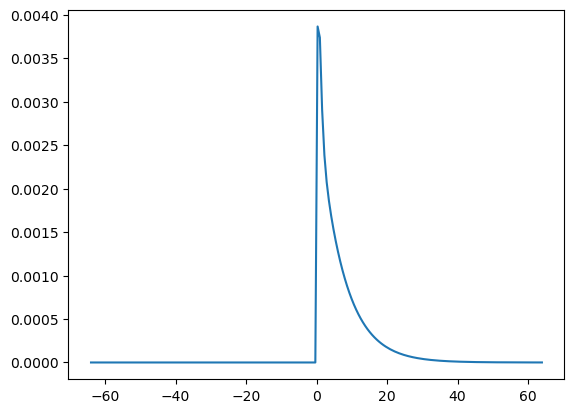

In [36]:
x = time_series
y = avg_pulse
popt, pconv, info, f = hp.fit_curve(hp.Pulse2,data['time_series_ns'],data['averaged_pulse_1pe_volt'],p0=[2,4,10,0.001,0.001,0,0.008])

# Example 1: generate a pulse repetitively 

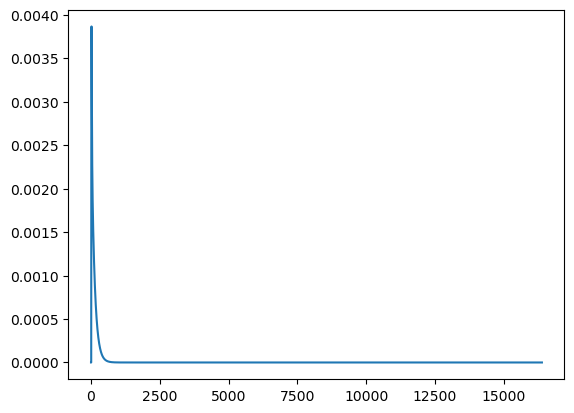

In [37]:
waveform_length = 16384
samples_per_ns = 16 # 2.5 Gsps --> 2.5 samples per ns
samples_per_s = samples_per_ns*1e9
waveform_duration = waveform_length/samples_per_ns
ch=1

time_series = (np.arange(waveform_length)-10)/samples_per_ns
# time_series = (np.arange(waveform_length)-waveform_length//2)/samples_per_ns
waveform_1eh = hp.Pulse2(time_series, *popt)
# waveform_14bit = hp.float_to_ADU(waveform, bits=14)    
plot(waveform_1eh)


In [38]:
waveform_14bit = hp.float_to_ADU(waveform_1eh,bits=14)
output_voltage = np.max(waveform_1eh)*10*49/27
if output_voltage<0.05:
    output_voltage = 0.05
vs.upload_waveform(funcgen, waveform_14bit, waveform_duration = waveform_duration, ch=ch, trigger_mode="INTernal2", output_voltage=output_voltage)

0.000677772085586298


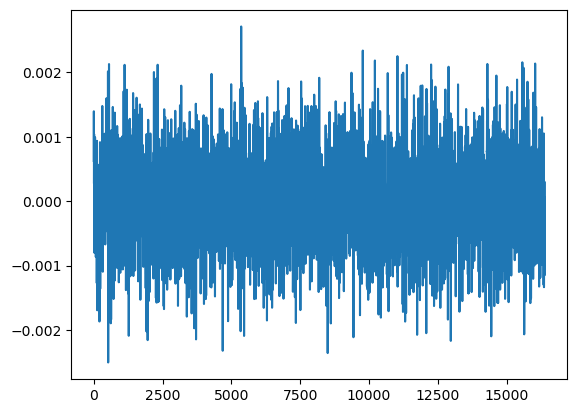

In [39]:
noise_voltage_density = 2.5*1e-9 * 7 # 2.5 nV/rtHz * gain=7
noise_trace = hp.band_limited_noise(0, 1.5e9, samples=waveform_length, samplerate=samples_per_s)* noise_voltage_density
plot(noise_trace)
print(std(noise_trace))

## Examples

In [85]:
# Signal size and trigger
n_expected = 20 # number of eh expected
n_threshold = 1 # threshold [eh]

# WLS fiber parameter
WLS_t_decay = 2 # [ns]
# No laser parameter
#Plastic Scintillator Parameter
psdec = 3.0


# Run parameters
N_EXPERIMENTS = 4000
N_PLOTS = N_EXPERIMENTS
SEED = 1


noise_temp = 0

results_trigger_time, results_pulses, _ = vs.mc_exp_decay_withps(n_expected, n_threshold, WLS_t_decay, psdec, LASER_time_spread,
                                                       N_EXPERIMENTS =N_EXPERIMENTS, N_PLOTS=N_PLOTS, SEED=SEED,
                                                       PULSE=waveform_1eh, Fs=samples_per_ns, noise_voltage_density=noise_temp)

100%|██████████| 4000/4000 [00:02<00:00, 1420.38it/s]


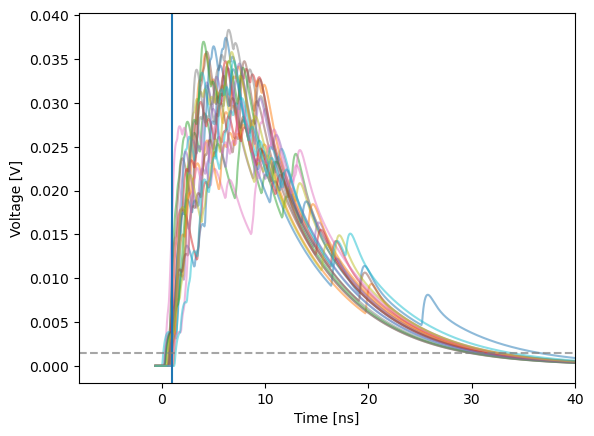

In [86]:
trigger_threshold = 0.0015*1


for i in range(20):
    plot(time_series, results_pulses[i],alpha=0.5)
    # plot(time_series, np.roll(results_pulses[i],-results_trigger_time[i]+8192),alpha=0.3)
xlim(-8,40)
xlabel("Time [ns]")
ylabel("Voltage [V]")
axvline(1)
axhline(trigger_threshold, color="grey", linestyle="--", alpha=0.7)
show()

In [87]:
trigger_times = []
trigger_slope = []
for pulse in results_pulses:
    trigpt = int(np.argmax(pulse>trigger_threshold))
    trigger_times.append(time_series[trigpt])
    trigger_slope.append((pulse[trigpt+1]-pulse[trigpt])/(time_series[trigpt+1]-time_series[trigpt])*1000)
    # trigger_slope.append((pulse[trigpt+1]-pulse[trigpt])/(time_series[trigpt+1]-time_series[trigpt])*1000)

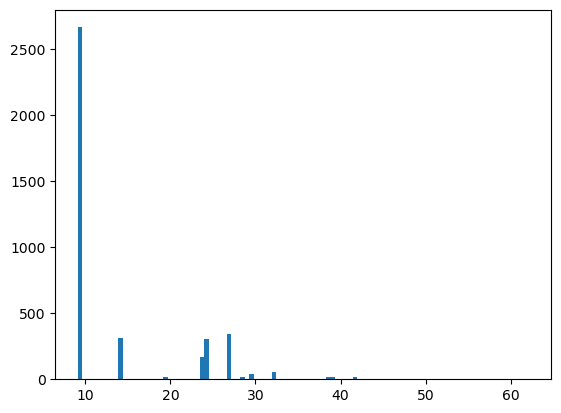

In [88]:
hist(trigger_slope,bins=100);

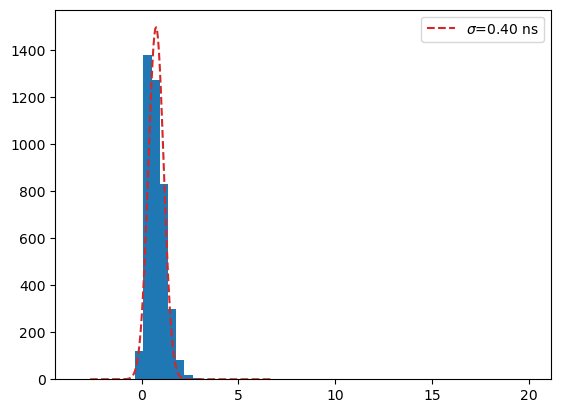

In [89]:
h = hist(trigger_times,bins=55, range=(-3.3,20));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--", fit_range=(-3,7));
legend()

In [90]:
amp_1eh_raw = np.max(waveform_1eh)*5/3
amp_1eh_at_asic = amp_1eh_raw*27/49
amp_1eh_at_disc = amp_1eh_at_asic*100
threshold = 0.15*20/63
threshold_eh = threshold/amp_1eh_at_disc
print(threshold_eh)

0.1340597737608661


In [102]:

reload(vs)

<module 'helper_visa' from '/home/mathusla/tofpet/Mu-Hardware/Keysight/../helper_visa.py'>

In [137]:
# Signal size and trigger
n_expected = 26 # number of eh expected
n_threshold = 0 # threshold [eh]

# WLS fiber parameter
WLS_t_decay = 2 # [ns]
# Laser parameter
LASER_time_spread = 0
#Plastic Scintillator parameter
psdec = 3.0

# Run parameters
N_EXPERIMENTS = 2000
N_PLOTS = N_EXPERIMENTS
SEED = 1

results_trigger_time, results_pulses, _ = vs.mc_exp_decay_withps(n_expected, n_threshold, WLS_t_decay, psdec, LASER_time_spread, N_EXPERIMENTS =N_EXPERIMENTS, N_PLOTS=N_PLOTS, SEED=SEED, PULSE=waveform_1eh, Fs=samples_per_ns, noise_voltage_density=noise_voltage_density)

100%|██████████| 2000/2000 [00:00<00:00, 3287.15it/s]


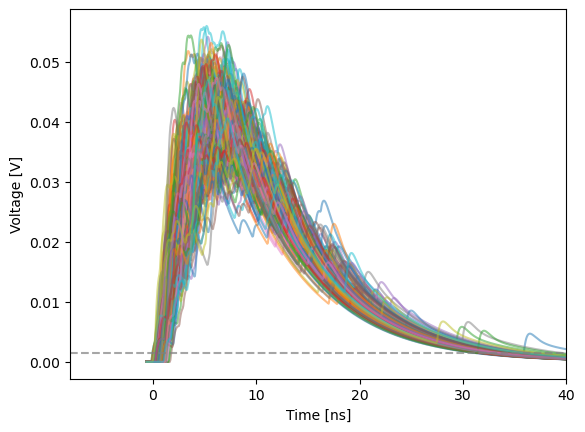

In [138]:
for i in range(200):
    plot(time_series, results_pulses[i],alpha=0.5)
    # plot(time_series, np.roll(results_pulses[i],-results_trigger_time[i]+8192),alpha=0.3)
xlim(-8,40)
xlabel("Time [ns]")
ylabel("Voltage [V]")
axhline(trigger_threshold, color="grey", linestyle="--", alpha=0.7)
show()



trigger_times = []
for pulse in results_pulses:
    trigger_times.append(time_series[np.argmax(pulse>trigger_threshold)])

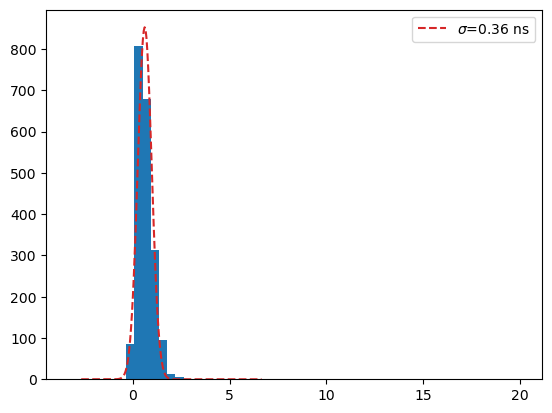

In [139]:
h = hist(trigger_times,bins=55, range=(-3.3,20));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--", fit_range=(-3,7));
legend()

In [53]:
dummy_pulse_avg = np.mean(results_pulses, axis=0)
scintillator_pulse_15eh_save = np.load("scintillator_pulse_15eh.npy")
time_series_15eh, scintillator_pulse_15eh, scintillator_pulse_15eh_std = scintillator_pulse_15eh_save

FileNotFoundError: [Errno 2] No such file or directory: 'scintillator_pulse_15eh.npy'

In [31]:
# time_series2 = (np.arange(waveform_length)-waveform_length//2)/samples_per_ns
# waveform_1eh2 = hp.Pulse2(time_series2, *popt)

# decay_kernel = scipy.stats.expon.pdf(time_series2, scale=WLS_t_decay)
# waveform_1eh_smeared = scipy.signal.convolve(waveform_1eh2,decay_kernel, mode="same")

TypeError: Pulse2() missing 4 required positional arguments: 'A1', 'A2', 't0', and 'A0'

In [ ]:
# # plot(time_series2, waveform_1eh2)
# plot(time_series_15eh, scintillator_pulse_15eh)
# # plot(time_series2-0.3, waveform_1eh_smeared/max(waveform_1eh_smeared)*max(dummy_pulse_avg))
# plot(time_series-3.5, dummy_pulse_avg*1.15)

# xlim(-10,50)
# grid()

# Open the function generator and generate pulses

In [141]:
# funcgen = vs.connect(timeout=30000) # set 30 second timeout
funcgen = vs.connect("TCPIP0::192.168.1.9::inst0::INSTR", timeout=10000) # set 30 second timeout
# funcgen = vs.connect("USB0::0x0957::0x4108::MY60410882::0::INSTR", timeout=10000) # set 30 second timeout

# vs.disconnect(funcgen)

Connected to VISA [TCPIP0::192.168.1.9::inst0::INSTR]:  Agilent Technologies,81160A,MY60410882,2.0.0.0-2.6



In [140]:
vs.disconnect(funcgen)

## 1. Generate toy data waveform

In [142]:
funcgen.write(":DISP OFF");

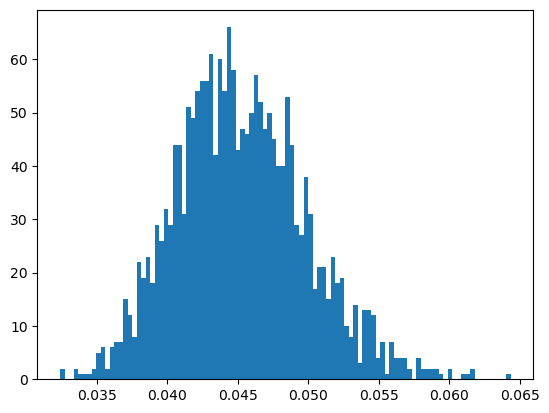

In [143]:
amps=[max(pulse) for pulse in results_pulses]
hist(amps,bins=100);

In [144]:
for i in tqdm(range(len(results_pulses))):
# for i in tqdm(range(7000)):
# for i in tqdm(range(20)):
    
    INIT = True if i==0 else False

    # INIT=False

    funcgen.write(f":OUTPut1 OFF");      # Output the selected arb waveform  
    # funcgen.write(f":OUTPut2 OFF");      # Output the selected arb waveform  

    # Upload the first waveform
    j = np.random.randint(0,len(results_pulses))
    waveform_14bit = hp.float_to_ADU(results_pulses[j], bits=14)  
    output_voltage = np.max(results_pulses[j])*10
    if output_voltage<0.05:
        output_voltage = 0.05
    vs.upload_waveform(funcgen, waveform_14bit, waveform_duration = waveform_duration, ch=1, trigger_mode="MAN", output_voltage=output_voltage, RESET=False, INIT=INIT)
    time.sleep(0.01)
    
    
    # Upload the second waveform
    # j = np.random.randint(0,len(results_pulses))
    # waveform_14bit = hp.float_to_ADU(results_pulses[j], bits=14)  
    # output_voltage = np.max(results_pulses[j])*10
    # if output_voltage<0.05:
    #     output_voltage = 0.05
    # vs.upload_waveform(funcgen, waveform_14bit, waveform_duration = waveform_duration, ch=2, trigger_mode="MAN", output_voltage=output_voltage, RESET=False, INIT=INIT)
    # time.sleep(0.01)    
    
    funcgen.write(f":OUTPut1 ON");      # Output the selected arb waveform  
    # funcgen.write(f":OUTPut2 ON");      # Output the selected arb waveform        
    
    vs.trigger(funcgen)

    time.sleep(0.1)

100%|██████████| 2000/2000 [09:14<00:00,  3.61it/s]


In [ ]:
plot(results_pulses[j][:100])
axhline(0)

## 2. Generate the same averaged pulse 

In [ ]:
dummy_pulse_avg_normd = dummy_pulse_avg/max(dummy_pulse_avg)
output_voltage = max(dummy_pulse_avg)*20
waveform_14bit = hp.float_to_ADU(-dummy_pulse_avg, bits=14)  
vs.upload_waveform(funcgen, waveform_14bit, waveform_duration = waveform_duration, ch=ch, trigger_mode="MAN",trigger_freq=500, output_voltage=output_voltage, RESET=False)

In [ ]:
for i in tqdm(range(10000)):
    vs.trigger(funcgen)
    time.sleep(0.003)    

# Analysis

In [ ]:
DATA_DIR = "E:\\sync\\DT5550W\\"
filename = f"{DATA_DIR}\\176.data"

data  = hpt.load_finetime(filename, chs =["16","17"])

In [ ]:
mask_hit16 = (data["HIT_16"]==1)
mask_hit17 = (data["HIT_17"]==1)
mask_coinc = mask_hit16&mask_hit17

hist((data["CHARGE_17"]),bins=np.linspace(0,200,201),histtype="step", label="CH16");
hist((data["CHARGE_17"])[mask_hit17],bins=np.linspace(0,200,201),histtype="step", label="CH16");
hist((data["CHARGE_17"])[mask_coinc],bins=np.linspace(0,200,201),histtype="step", label="CH16");
yscale("log")
grid()

In [ ]:
sum(mask_hit16)

In [ ]:
h=hist(data["FINE_17"], bins=100);


In [ ]:
dt_coinc = (data.TIMESTAMP_16-data.TIMESTAMP_17)


ftime_min=ftime_max=None
bins=np.linspace(0,25,240)
ch="0"
normed=False

mask_peak1 = mask_coinc& (np.abs(data["CHARGE_17"]-100)<15)

h=hist(dt_coinc[mask_peak1], bins=np.linspace(-25,25,200));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--");
legend()
xlabel("dt [ns]")    
show()    

In [ ]:
import random

In [ ]:
inds1 = np.arange(len(dt_coinc))
inds2 = np.arange(len(dt_coinc))
random.shuffle(inds1)
random.shuffle(inds2)

dt_coinc_shuffled = dt_coinc.values[inds1]-dt_coinc.values[inds2]

bins=np.linspace(0,25,240)

h=hist(dt_coinc_shuffled, bins=np.linspace(-10,10,100));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--");
legend()
xlabel("dt [ns]")    
show()    

In [ ]:
3.7/1.4

### Averaged pulse

In [ ]:
DATA_DIR = "E:\\sync\\DT5550W\\"
filename = f"{DATA_DIR}\\174.data"

data  = hpt.load_finetime(filename, chs =["16","17"])

In [ ]:
mask_hit16 = (data["HIT_16"]==1)
mask_hit17 = (data["HIT_17"]==1)
mask_coinc = mask_hit16&mask_hit17

hist((data["CHARGE_17"]),bins=np.linspace(0,200,201),histtype="step", label="CH16");
hist((data["CHARGE_17"])[mask_coinc],bins=np.linspace(0,200,201),histtype="step", label="CH16");
yscale("log")
grid()

In [ ]:
bins=np.linspace(0,25,120)

hist(data.FINE_calib_17, bins=bins)
hist(data.FINE_calib_17[mask_coinc], bins=bins)
xlabel("Fine Time")
yscale("log")

In [ ]:
sum(mask_coinc)/len(mask_coinc)

In [ ]:
dt_coinc = (data.TIMESTAMP_16-data.TIMESTAMP_17)


ftime_min=ftime_max=None
bins=np.linspace(0,25,240)
ch="0"
normed=False

mask_peak1 = mask_coinc#& (np.abs(data["CHARGE_17"]-100)<15)

h=hist(dt_coinc[mask_peak1], bins=np.linspace(-15,5,200));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns", color="C3", linestyle="--");
legend()
xlabel("dt [ns]")    
show()    